<a href="https://colab.research.google.com/github/tctr/genaibook_for_colab/blob/master/DiffBending_Official.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Differentiable Network Bending

Interactive Colab for our paper [Hacking Generative Models with Differentiable Network Bending](https://arxiv.org/abs/2310.04816), to appear at the NeurIPS 2023 workshop on [Machine Learning for Creativity and Design](https://neuripscreativityworkshop.github.io/2023/).

In this work, we propose a method to 'hack' generative models, pushing their outputs away from the original training distribution towards a new objective. We inject a small-scale trainable module between the intermediate layers of the model and train it for a low number of iterations, keeping the rest of the network frozen. The resulting output images display an uncanny quality, given by the tension between the original and new objectives that can be exploited for artistic purposes.

In [1]:
#@title Install required packages
!pip install git+https://github.com/huggingface/community-events.git
!pip install open_clip_torch
!pip install diffsort

  Cloning https://github.com/huggingface/community-events.git to /tmp/pip-req-build-pplo53ja
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/community-events.git /tmp/pip-req-build-pplo53ja
  Resolved https://github.com/huggingface/community-events.git to commit a2d9115007c7e44b4389e005ea5c6163ae5b0470
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.7/285.7 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.1 MB/s eta 0:00:00
     ━

In [2]:
# @title Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import torchvision.transforms as T
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import gc
from huggan.pytorch.lightweight_gan.lightweight_gan import is_power_of_two, default, \
  PreNorm, LinearAttention, FCANet, GlobalContext, upsample, exists
from einops import rearrange
from collections import OrderedDict
from diffsort import DiffSortNet
import open_clip
from huggingface_hub import hf_hub_download
from math import log2
import random

/usr/local/lib/python3.10/dist-packages/kornia/augmentation/augmentation.py:1830: DeprecationWarning: GaussianBlur is no longer maintained and will be removed from the future versions. Please use RandomGaussianBlur instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:49: DeprecationWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", DeprecationWarning)


In [3]:
# @title Settings (random seeds and device)
seeds = [i for i in range(16)]
device = 'cuda' # @param ['cuda', 'cpu']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# @title "Bendable" GAN generator class
class BendedGenerator(nn.Module):
    def __init__(
            self,
            *,
            image_size,
            bending_module=None,
            bending_idx=None,
            train_bending=False,
            latent_dim=256,
            fmap_max=512,
            fmap_inverse_coef=12,
            transparent=False,
            greyscale=False,
            attn_res_layers=[32],
            freq_chan_attn=False
    ):
        super().__init__()

        self.image_size = image_size
        self.latent_dim = latent_dim
        self.bending_module = bending_module
        self.bending_idx = bending_idx
        self.train_bending = train_bending

        norm_class = nn.BatchNorm2d
        Blur = nn.Identity

        resolution = log2(image_size)
        assert is_power_of_two(image_size), 'image size must be a power of 2'

        if transparent:
            init_channel = 4
        elif greyscale:
            init_channel = 1
        else:
            init_channel = 3

        fmap_max = default(fmap_max, latent_dim)

        self.initial_conv = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, latent_dim * 2, 4),
            nn.BatchNorm2d(latent_dim * 2),
            nn.GLU(dim=1)
        )

        num_layers = int(resolution) - 2
        features = list(map(lambda n: (n, 2 ** (fmap_inverse_coef - n)), range(2, num_layers + 2)))
        features = list(map(lambda n: (n[0], min(n[1], fmap_max)), features))
        features = list(map(lambda n: 3 if n[0] >= 8 else n[1], features))
        features = [latent_dim, *features]

        in_out_features = list(zip(features[:-1], features[1:]))

        self.res_layers = range(2, num_layers + 2)
        self.layers = nn.ModuleList([])
        self.res_to_feature_map = dict(zip(self.res_layers, in_out_features))

        self.sle_map = ((3, 7), (4, 8), (5, 9), (6, 10))
        self.sle_map = list(filter(lambda t: t[0] <= resolution and t[1] <= resolution, self.sle_map))
        self.sle_map = dict(self.sle_map)

        self.num_layers_spatial_res = 1

        for (res, (chan_in, chan_out)) in zip(self.res_layers, in_out_features):
            image_width = 2 ** res

            attn = None
            if image_width in attn_res_layers:
                attn = PreNorm(chan_in, LinearAttention(chan_in))

            sle = None
            if res in self.sle_map:
                residual_layer = self.sle_map[res]
                sle_chan_out = self.res_to_feature_map[residual_layer - 1][-1]

                if freq_chan_attn:
                    sle = FCANet(
                        chan_in=chan_out,
                        chan_out=sle_chan_out,
                        width=2 ** (res + 1)
                    )
                else:
                    sle = GlobalContext(
                        chan_in=chan_out,
                        chan_out=sle_chan_out
                    )

            layer = nn.ModuleList([
                nn.Sequential(
                    upsample(),
                    Blur(),
                    nn.Conv2d(chan_in, chan_out * 2, 3, padding=1),
                    norm_class(chan_out * 2),
                    nn.GLU(dim=1)
                ),
                sle,
                attn
            ])

            self.layers.append(layer)

        # Check that the channels of the bending module match
        # those of the target layer
        if bending_idx and bending_module:
            bentchannels = self.layers[bending_idx][0][2].out_channels
            assert bending_module.in_channels == bending_module.out_channels == bentchannels

        self.out_conv = nn.Conv2d(features[-1], init_channel, 3, padding=1)

    def forward(self, x, bend=True, return_inout=False, perm_h=None):
        x = rearrange(x, 'b c -> b c () ()')
        x = self.initial_conv(x)
        x = F.normalize(x, dim=1)

        bend_in = None
        bend_out = None

        residuals = dict()

        for (i, res, (up, sle, attn)) in zip(range(len(self.layers)), self.res_layers, self.layers):

            if exists(attn):
                x = attn(x) + x

            x = up[:3](x)
            # Just to get the tensor sizes
            #print('Layer:', i, 'Input shape:', x.shape,
            #      'bending:', i == self.bending_idx)
            if bend and i == self.bending_idx and self.bending_module is not None:
                bend_in = x
                if perm_h is not None:
                    x = x[:, :, perm_h, :]
                x = self.bending_module(x)
                bend_out = x

            x = up[3:](x)

            if exists(sle):
                out_res = self.sle_map[res]
                residual = sle(x)
                residuals[out_res] = residual

            next_res = res + 1
            if next_res in residuals:
                x = x * residuals[next_res]
        if return_inout:
            return self.out_conv(x), bend_in, bend_out
        else:
            return self.out_conv(x)

    @classmethod
    def from_pretrained(cls,
                        model_id,
                        image_size=512,
                        bending_module=None,
                        bending_idx=None,
                        train_bending=False,
                        map_location="cpu"):
        '''overrides method from ModelHubMixin'''

        model_file = hf_hub_download(
            repo_id=str(model_id),
            filename='model.pt',
            revision=None,
            cache_dir=None,
            force_download=False,
            proxies=None,
            resume_download=False,
            token=None,
            local_files_only=False
        )

        state_dict = torch.load(model_file,
                                map_location=map_location)['GAN']
        genstatedict = OrderedDict()
        for k, v in state_dict.items():
            if k[:2]=='G.':
                newk = k.replace('G.', '')
                genstatedict[newk] = v

        model = cls(image_size=image_size,
                    bending_module=bending_module,
                    bending_idx=bending_idx,
                    train_bending=train_bending)
        model.load_state_dict(genstatedict, strict=False)
        model.eval()

        for param in model.parameters():
            param.requires_grad = False
        if train_bending==True and bending_module is not None:
            for param in model.bending_module.parameters():
                param.requires_grad = True

        return model

    def to(self, device):
        new_self = super(BendedGenerator, self).to(device)
        if new_self.bending_module is not None:
            new_self.bending_module = new_self.bending_module.to(device)
        return new_self

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
# @title Bending module classes
class BendingConvModule(nn.Module):
    """
    Vanilla convolutional bending module.
    """
    def __init__(self, n_channels, act_fn='relu'):
        super(BendingConvModule, self).__init__()
        self.in_channels = self.out_channels = n_channels
        self.hid_channels = n_channels
        self.w1 = nn.Conv2d(self.in_channels,
                            self.hid_channels, 3,
                            padding='same')
        self.w2 = nn.Conv2d(self.hid_channels,
                            self.out_channels, 3,
                            padding='same')

        if act_fn == 'relu':
            self.act_fn = F.relu
        elif act_fn == 'sin':
            self.act_fn = torch.sin

    def forward(self, x):
        x = self.w1(x)
        x = self.act_fn(x)
        return self.w2(x)

class BendingConvModule_XY(nn.Module):
    """
    Convolutional bending module with coordinates
    appended as additional feature channels.
    """
    def __init__(self, n_channels, input_size,
                 act_fn='relu', use_rad=False,
                 device='cuda'):
        super(BendingConvModule_XY, self).__init__()
        self.device = device
        self.input_size = input_size
        self.in_channels = n_channels
        self.act_fn = act_fn
        self.use_rad = use_rad
        self.out_channels = self.hid_channels = n_channels
        extra_chans = 3 if use_rad else 2
        self.w1 = nn.Conv2d(self.in_channels + extra_chans,
                            self.hid_channels, 3,
                            padding='same')
        self.w2 = nn.Conv2d(self.hid_channels,
                            self.out_channels, 3,
                            padding='same')
        self.x, self.y = self._create_grid(input_size)
        self.r = self._create_radial(input_size)
        self.sinx = torch.sin(self.x)
        self.siny = torch.sin(self.y)

    def _create_grid(self, input_size):
        x, y = torch.meshgrid(torch.arange(input_size),
                              torch.arange(input_size),
                              indexing='xy')
        return x.float().to(self.device), y.float().to(self.device)

    def _create_radial(self, input_size):
        center = input_size // 2
        rx, ry = torch.meshgrid(torch.arange(input_size) - center,
                                torch.arange(input_size) - center,
                                indexing='xy')
        radial = torch.sqrt(rx ** 2 + ry ** 2)
        return radial.to(self.device)

    def to(self, device):
        new_self = super(BendingConvModule_XY, self).to(device)
        new_self.x = new_self.x.to(device)
        new_self.y = new_self.y.to(device)
        new_self.r = new_self.r.to(device)
        new_self.sinx = new_self.sinx.to(device)
        new_self.siny = new_self.siny.to(device)

        return new_self

    def forward(self, inp):
        batch_size = inp.shape[0]
        in_size = inp.shape[2]
        assert in_size == self.input_size

        x = torch.tile(self.x[None, None, ...], # add batch and channel dims
                       (batch_size, 1, 1, 1))
        y = torch.tile(self.y[None, None, ...],
                       (batch_size, 1, 1, 1))
        r = torch.tile(self.r[None, None, ...],
                       (batch_size, 1, 1, 1))
        sinx = torch.tile(self.sinx[None, None, ...],
                       (batch_size, 1, 1, 1))
        siny = torch.tile(self.siny[None, None, ...],
                       (batch_size, 1, 1, 1))

        inp = torch.cat((x, y, inp), dim=1)
        if self.use_rad:
            inp = torch.cat((r, inp), dim=1)

        inp = self.w1(inp)
        if self.act_fn == 'relu':
            inp = F.relu(inp)
        elif self.act_fn == 'sin':
            inp = torch.sin(inp)
        return self.w2(inp)

class BendingDiffSort_XY(nn.Module):
    """
    Differentiable sorting across the activation map's
    width and height. Can permute rows, columns or both.
    """
    def __init__(self, n_channels, input_size,
                 perm_rows=True, perm_cols=True, steepness=50):
        super(BendingDiffSort_XY, self).__init__()
        self.in_channels = self.out_channels = n_channels
        self.hid_channels = n_channels * 2
        self.input_size = input_size

        if not perm_rows and not perm_cols:
            raise ValueError('At least one of perm_rows and perm_cols needs to be true!')
        self.perm_rows = perm_rows
        self.perm_cols = perm_cols

        self.steepness = steepness

        self.feat_extractor = nn.Sequential(
            nn.Conv2d(self.in_channels, self.hid_channels,
                      1, padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.hid_channels, self.hid_channels,
                      1, padding='same'),
            nn.ReLU(inplace=True)
            )

        if self.perm_rows:
            self.rowwise = nn.Conv1d(self.hid_channels * self.input_size,
                                    1, 1)

            self.row_sorter = DiffSortNet('bitonic',
                                        self.input_size,
                                        steepness=self.steepness)


        if self.perm_cols:
            self.colwise = nn.Conv1d(self.hid_channels * self.input_size,
                                    1, 1)

            self.col_sorter = DiffSortNet('bitonic',
                                        self.input_size,
                                        steepness=self.steepness)

    def to(self, device):
        new_self = super(BendingDiffSort_XY, self).to(device)
        if self.perm_rows:
            new_self.row_sorter = DiffSortNet('bitonic',
                                            self.input_size,
                                            steepness=self.steepness,
                                            device=device)
        if self.perm_cols:
            new_self.col_sorter = DiffSortNet('bitonic',
                                            self.input_size,
                                            steepness=self.steepness,
                                            device=device)

        return new_self

    def forward(self, x):

        batch_size = x.shape[0]

        out = self.feat_extractor(x)

        if self.perm_rows:

            out_rows = out.permute(0, 2, 1, 3).reshape(batch_size,
                                                    self.input_size,
                                                    -1).permute(0, 2, 1)

            row_scores = self.rowwise(out_rows).flatten(1)
            _, sort_row_mat = self.row_sorter(row_scores)

            # First sort rows
            x = x.view(-1, self.input_size, self.input_size)
            sort_row_mat = sort_row_mat.unsqueeze(1).repeat(
                1, self.in_channels, 1, 1).view(
                    -1, self.input_size, self.input_size
                )
            x = torch.bmm(sort_row_mat, x).view(batch_size,
                                                self.in_channels,
                                                self.input_size,
                                                self.input_size)

        if self.perm_cols:

            out_cols = out.permute(0, 3, 1, 2).reshape(batch_size,
                                                    self.input_size,
                                                    -1).permute(0, 2, 1)

            col_scores = self.colwise(out_cols).flatten(1)


            _, sort_col_mat = self.col_sorter(col_scores)

            x = x.permute(0, 1, 3, 2).view(-1,
                                        self.input_size,
                                        self.input_size)
            sort_col_mat = sort_col_mat.unsqueeze(1).repeat(
                1, self.in_channels, 1, 1).view(
                    -1, self.input_size, self.input_size
                )
            x = torch.bmm(sort_col_mat, x).view(batch_size,
                                                self.in_channels,
                                                self.input_size,
                                                self.input_size)

class ConcatenatedModules(nn.Module):
    """
    Wrapper class to apply multiple modules in sequence.
    Used to combine diffsort + convolutional bending
    """
    def __init__(self, modules):
        super(ConcatenatedModules, self).__init__()
        self.mod_list = nn.ModuleList(modules)
        self.mods = nn.Sequential(*self.mod_list)
        self.in_channels = modules[0].in_channels
        self.out_channels = modules[-1].out_channels

    def to(self, device):
        new_self = super(ConcatenatedModules, self).to(device)
        for m in self.mod_list:
            m.to(device)
        new_self.mods = nn.Sequential(*self.mod_list)

        return new_self

    def forward(self, x):
        return self.mods(x)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# @title Loss functions
class InfoNCE(nn.Module):
    """
    Calculates the InfoNCE loss for self-supervised learning.
    This contrastive loss enforces the embeddings of similar (positive) samples to be close
        and those of different (negative) samples to be distant.
    A query embedding is compared with one positive key and with one or more negative keys.
    References:
        https://arxiv.org/abs/1807.03748v2
        https://arxiv.org/abs/2010.05113
    Args:
        temperature: Logits are divided by temperature before calculating the cross entropy.
        reduction: Reduction method applied to the output.
            Value must be one of ['none', 'sum', 'mean'].
            See torch.nn.functional.cross_entropy for more details about each option.
        negative_mode: Determines how the (optional) negative_keys are handled.
            Value must be one of ['paired', 'unpaired'].
            If 'paired', then each query sample is paired with a number of negative keys.
            Comparable to a triplet loss, but with multiple negatives per sample.
            If 'unpaired', then the set of negative keys are all unrelated to any positive key.
    Input shape:
        query: (N, D) Tensor with query samples (e.g. embeddings of the input).
        positive_key: (N, D) Tensor with positive samples (e.g. embeddings of augmented input).
        negative_keys (optional): Tensor with negative samples (e.g. embeddings of other inputs)
            If negative_mode = 'paired', then negative_keys is a (N, M, D) Tensor.
            If negative_mode = 'unpaired', then negative_keys is a (M, D) Tensor.
            If None, then the negative keys for a sample are the positive keys for the other samples.
    Returns:
         Value of the InfoNCE Loss.
     Examples:
        >>> loss = InfoNCE()
        >>> batch_size, num_negative, embedding_size = 32, 48, 128
        >>> query = torch.randn(batch_size, embedding_size)
        >>> positive_key = torch.randn(batch_size, embedding_size)
        >>> negative_keys = torch.randn(num_negative, embedding_size)
        >>> output = loss(query, positive_key, negative_keys)
    """

    def __init__(self, temperature=0.1, reduction='mean', negative_mode='unpaired'):
        super().__init__()
        self.temperature = temperature
        self.reduction = reduction
        self.negative_mode = negative_mode

    def forward(self, query, positive_key, negative_keys=None):
        return info_nce(query, positive_key, negative_keys,
                        temperature=self.temperature,
                        reduction=self.reduction,
                        negative_mode=self.negative_mode)


def info_nce(query, positive_key, negative_keys=None, temperature=0.1, reduction='mean', negative_mode='unpaired'):
    # Check input dimensionality.
    if query.dim() != 2:
        raise ValueError('<query> must have 2 dimensions.')
    if positive_key.dim() != 2:
        raise ValueError('<positive_key> must have 2 dimensions.')
    if negative_keys is not None:
        if negative_mode == 'unpaired' and negative_keys.dim() != 2:
            raise ValueError("<negative_keys> must have 2 dimensions if <negative_mode> == 'unpaired'.")
        if negative_mode == 'paired' and negative_keys.dim() != 3:
            raise ValueError("<negative_keys> must have 3 dimensions if <negative_mode> == 'paired'.")

    # Check matching number of samples.
    if len(query) != len(positive_key):
        raise ValueError('<query> and <positive_key> must must have the same number of samples.')
    if negative_keys is not None:
        if negative_mode == 'paired' and len(query) != len(negative_keys):
            raise ValueError("If negative_mode == 'paired', then <negative_keys> must have the same number of samples as <query>.")

    # Embedding vectors should have same number of components.
    if query.shape[-1] != positive_key.shape[-1]:
        raise ValueError('Vectors of <query> and <positive_key> should have the same number of components.')
    if negative_keys is not None:
        if query.shape[-1] != negative_keys.shape[-1]:
            raise ValueError('Vectors of <query> and <negative_keys> should have the same number of components.')

    # Normalize to unit vectors
    query, positive_key, negative_keys = normalize(query, positive_key, negative_keys)
    if negative_keys is not None:
        # Explicit negative keys

        # Cosine between positive pairs
        positive_logit = torch.sum(query * positive_key, dim=1, keepdim=True)

        if negative_mode == 'unpaired':
            # Cosine between all query-negative combinations
            negative_logits = query @ transpose(negative_keys)

        elif negative_mode == 'paired':
            query = query.unsqueeze(1)
            negative_logits = query @ transpose(negative_keys)
            negative_logits = negative_logits.squeeze(1)

        # First index in last dimension are the positive samples
        logits = torch.cat([positive_logit, negative_logits], dim=1)
        labels = torch.zeros(len(logits), dtype=torch.long, device=query.device)
    else:
        # Negative keys are implicitly off-diagonal positive keys.

        # Cosine between all combinations
        logits = query @ transpose(positive_key)

        # Positive keys are the entries on the diagonal
        labels = torch.arange(len(query), device=query.device)

    return F.cross_entropy(logits / temperature, labels, reduction=reduction)
    # return 1.0 - torch.nn.CosineSimilarity()(logits / temperature, labels)

def transpose(x):
    return x.transpose(-2, -1)


def normalize(*xs):
    return [None if x is None else F.normalize(x, dim=-1) for x in xs]

class CLIP(torch.nn.Module):
    """
    Generic CLIP parent class
    """
    def __init__(self, prompt_text, device='cpu'):
        super(CLIP, self).__init__()

        self.clip_model, _, preprocess = open_clip.create_model_and_transforms(
        'ViT-B-32-quickgelu', pretrained='laion400m_e32'
        )
        self.clip_model.to(device)

        # Create transforms to feed images to CLIP:
        self.clip_tfms = T.Compose(preprocess.transforms[:2]+preprocess.transforms[-1:])

        self.prompt_text = prompt_text
        with torch.no_grad():
            tokenized_text = open_clip.tokenize([prompt_text]).to(device)
            self.prompt_embed = self.clip_model.encode_text(tokenized_text)

        # As a bonus, we can do some augmentation
        self.aug_tfms = T.Compose([
            T.RandomResizedCrop(480),
            T.RandomAffine(5),
            T.ColorJitter(),
            T.GaussianBlur(5)
        ])

    def get_embeddings(self, x, augment=True, normalize=True):
        if augment:
            x = self.aug_tfms(x)
        image_embeds = self.clip_model.encode_image(self.clip_tfms(x))
        if normalize:
            image_embeds = F.normalize(image_embeds, dim=1)
            prompt_embed = F.normalize(self.prompt_embed, dim=1)

        return image_embeds, prompt_embed


class NCELoss(CLIP):
    def __init__(self, prompt_text, temperature=0.1, device='cpu'):
        super(NCELoss, self).__init__(prompt_text, device=device)

        self.InfoNCE = InfoNCE(temperature=temperature,
                               negative_mode='paired')

    def filter_crossval(self, x, batch_size):
        """
        Simple utility to remove first element from the first
        (repeated) batch, second from second batch etc.
        """

        total_size = x.shape[0]
        removerows = torch.arange(batch_size) * (batch_size + 1)
        keeprows = torch.LongTensor([i for i in \
            torch.arange(total_size) if i not in removerows])

        return x[keeprows, :]

    def forward(self, x, augment=True, normalize=True):

        image_embeds, prompt_embed = self.get_embeddings(
            x, augment=augment, normalize=normalize)
        batch_size = x.shape[0]

        pos_key = prompt_embed.repeat(batch_size, 1)
        neg_keys = image_embeds.repeat(batch_size, 1)
        neg_keys = self.filter_crossval(neg_keys, batch_size).reshape(
            batch_size, batch_size-1, -1) # [N, M, D]

        return self.InfoNCE(image_embeds, pos_key, negative_keys=neg_keys)


class TextPrompt(CLIP):
    def __init__(self, prompt_text, device='cpu'):
        super(TextPrompt, self).__init__(prompt_text, device=device)

    def forward(self, x, augment=True, return_mean=True,
                normalize=True, diversity=False):
        """
        Take a batch of images (x), encode them with clip_model
        and score each with the prompt using Squared Great Circle Distance
        (Lower is better).
        """
        image_embeds, prompt_embed = self.get_embeddings(
            x, augment=augment, normalize=normalize)
        image_embeds = image_embeds.unsqueeze(1)
        prompt_embed = prompt_embed.unsqueeze(0)

        dists = image_embeds.sub(prompt_embed).norm(dim=2).div(2).arcsin().pow(2).mul(2)

        if diversity:
            batch_size = x.shape[0]
            assert batch_size % 2 == 0
            img_embeds1 = image_embeds[np.arange(0, batch_size, 2), ...]
            img_embeds2 = image_embeds[np.arange(1, batch_size, 2), ...]
            x1 = x[np.arange(0, batch_size, 2),
                   ...].reshape(batch_size//2, -1)
            x2 = x[np.arange(1, batch_size, 2),
                    ...].reshape(batch_size//2, -1)
            div_latents = img_embeds1.sub(img_embeds2).norm(dim=2).div(2).arcsin().pow(2).mul(2)
            #div_inputs = F.normalize(torch.mean(torch.abs(x1 - x2), axis=1), dim=0).reshape(-1, 1)

            diversities = 1./div_latents#/div_inputs
            if return_mean:
                return dists.mean(), diversities.mean()
            return dists, diversities

        if return_mean:
            return dists.mean()
        return dists

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
# @title Utilities for visualization

def generate_image_from_seed(model, bend=True, seed=0):
  model = model.to('cpu')
  torch.manual_seed(seed)
  with torch.no_grad():
        ims = model(torch.randn(1, model.latent_dim),
                    bend=bend)
        ims = ims.permute(0,2,3,1).clamp_(0., 1.)  * 255.
        ims = ims.detach().numpy().astype(np.uint8)
        # ims is [BxWxHxC] call Image.fromarray(ims[0])
  return Image.fromarray(ims[0])

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Train model

In [8]:
# @title Settings

prompt = 'Psychedelic painting of a multi-armed deity' # @param

numchans = [1024, 1024, 512, 256, 128, 64, 6]
inputsizes = [8, 16, 32, 64, 128, 256, 512]

# @markdown which layer to bend
bending_idx = 5 # @param {type: 'slider', min: 0, max: 6, step: 1}

whichmodel = 'conv' # @param ['conv', 'conv_coords']
diffsort = 'none' # @param ['none', 'rows', 'columns', 'both']

activation = 'relu' # @param ['relu', 'sin']

whichloss = 'clip' # @param ['clip', 'nce_clip']
# @markdown Temperature for NCE loss \
# @markdown (unused for standard CLIP loss!)
temperature = 1e-2 # @param

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
if whichmodel == 'conv':
  bendingmod = BendingConvModule(numchans[bending_idx],
                                 act_fn=activation)
elif whichmodel == 'conv_coords':
  bendingmod = BendingConvModule_XY(numchans[bending_idx],
                                    inputsizes[bending_idx],
                                    act_fn=activation,
                                    device=device)
if diffsort != 'none':
  if diffsort == 'rows':
    permrows, permcols = True, False
  elif diffsort == 'columns':
    permrows, permcols = False, True
  elif diffsort == 'both':
    permrows, permcols = True, True
  bendsorting = BendingDiffSort_XY(numchans[bending_idx],
                                   inputsizes[bending_idx],
                                   perm_rows=permrows, perm_cols=permcols)
  bendingmod = ConcatenatedModules([bendsorting, bendingmod])

if whichloss == 'clip':
  loss_fn = TextPrompt(prompt, device=device)
elif whichloss == 'nce_clip':
  loss_fn = NCELoss(prompt, device=device, temperature=temperature)

bended_generator = BendedGenerator.from_pretrained("ceyda/butterfly_cropped_uniq1K_512",
                                                   bending_module=bendingmod,
                                                   bending_idx=bending_idx,
                                                   train_bending=True)
bended_generator = bended_generator.to(device)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|███████████████████████████████████████| 605M/605M [00:06<00:00, 99.6MiB/s]


model.pt:   0%|          | 0.00/155M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


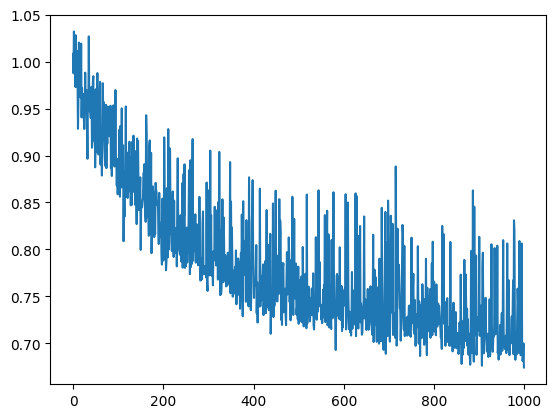

In [10]:
# @title Training Loop
torch.cuda.empty_cache()

random.seed(23456)
np.random.seed(54321)
torch.manual_seed(12345)

batch_size = 16

n_iter = 1000

opt = Adam(bendingmod.parameters(), 1e-4)

loss_log = []

for i in tqdm(range(n_iter)):

    noise_input = torch.randn(batch_size,
                    bended_generator.latent_dim,
                    device=device)

    out, b_in, _ = bended_generator(noise_input, return_inout=True)
    out = out.clamp_(0., 1.)

    loss = loss_fn(out)

    loss_log.append(loss.detach().cpu().numpy())

    with torch.no_grad():
        loss.backward()
        opt.step()
        opt.zero_grad()


plt.plot(range(n_iter), loss_log)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


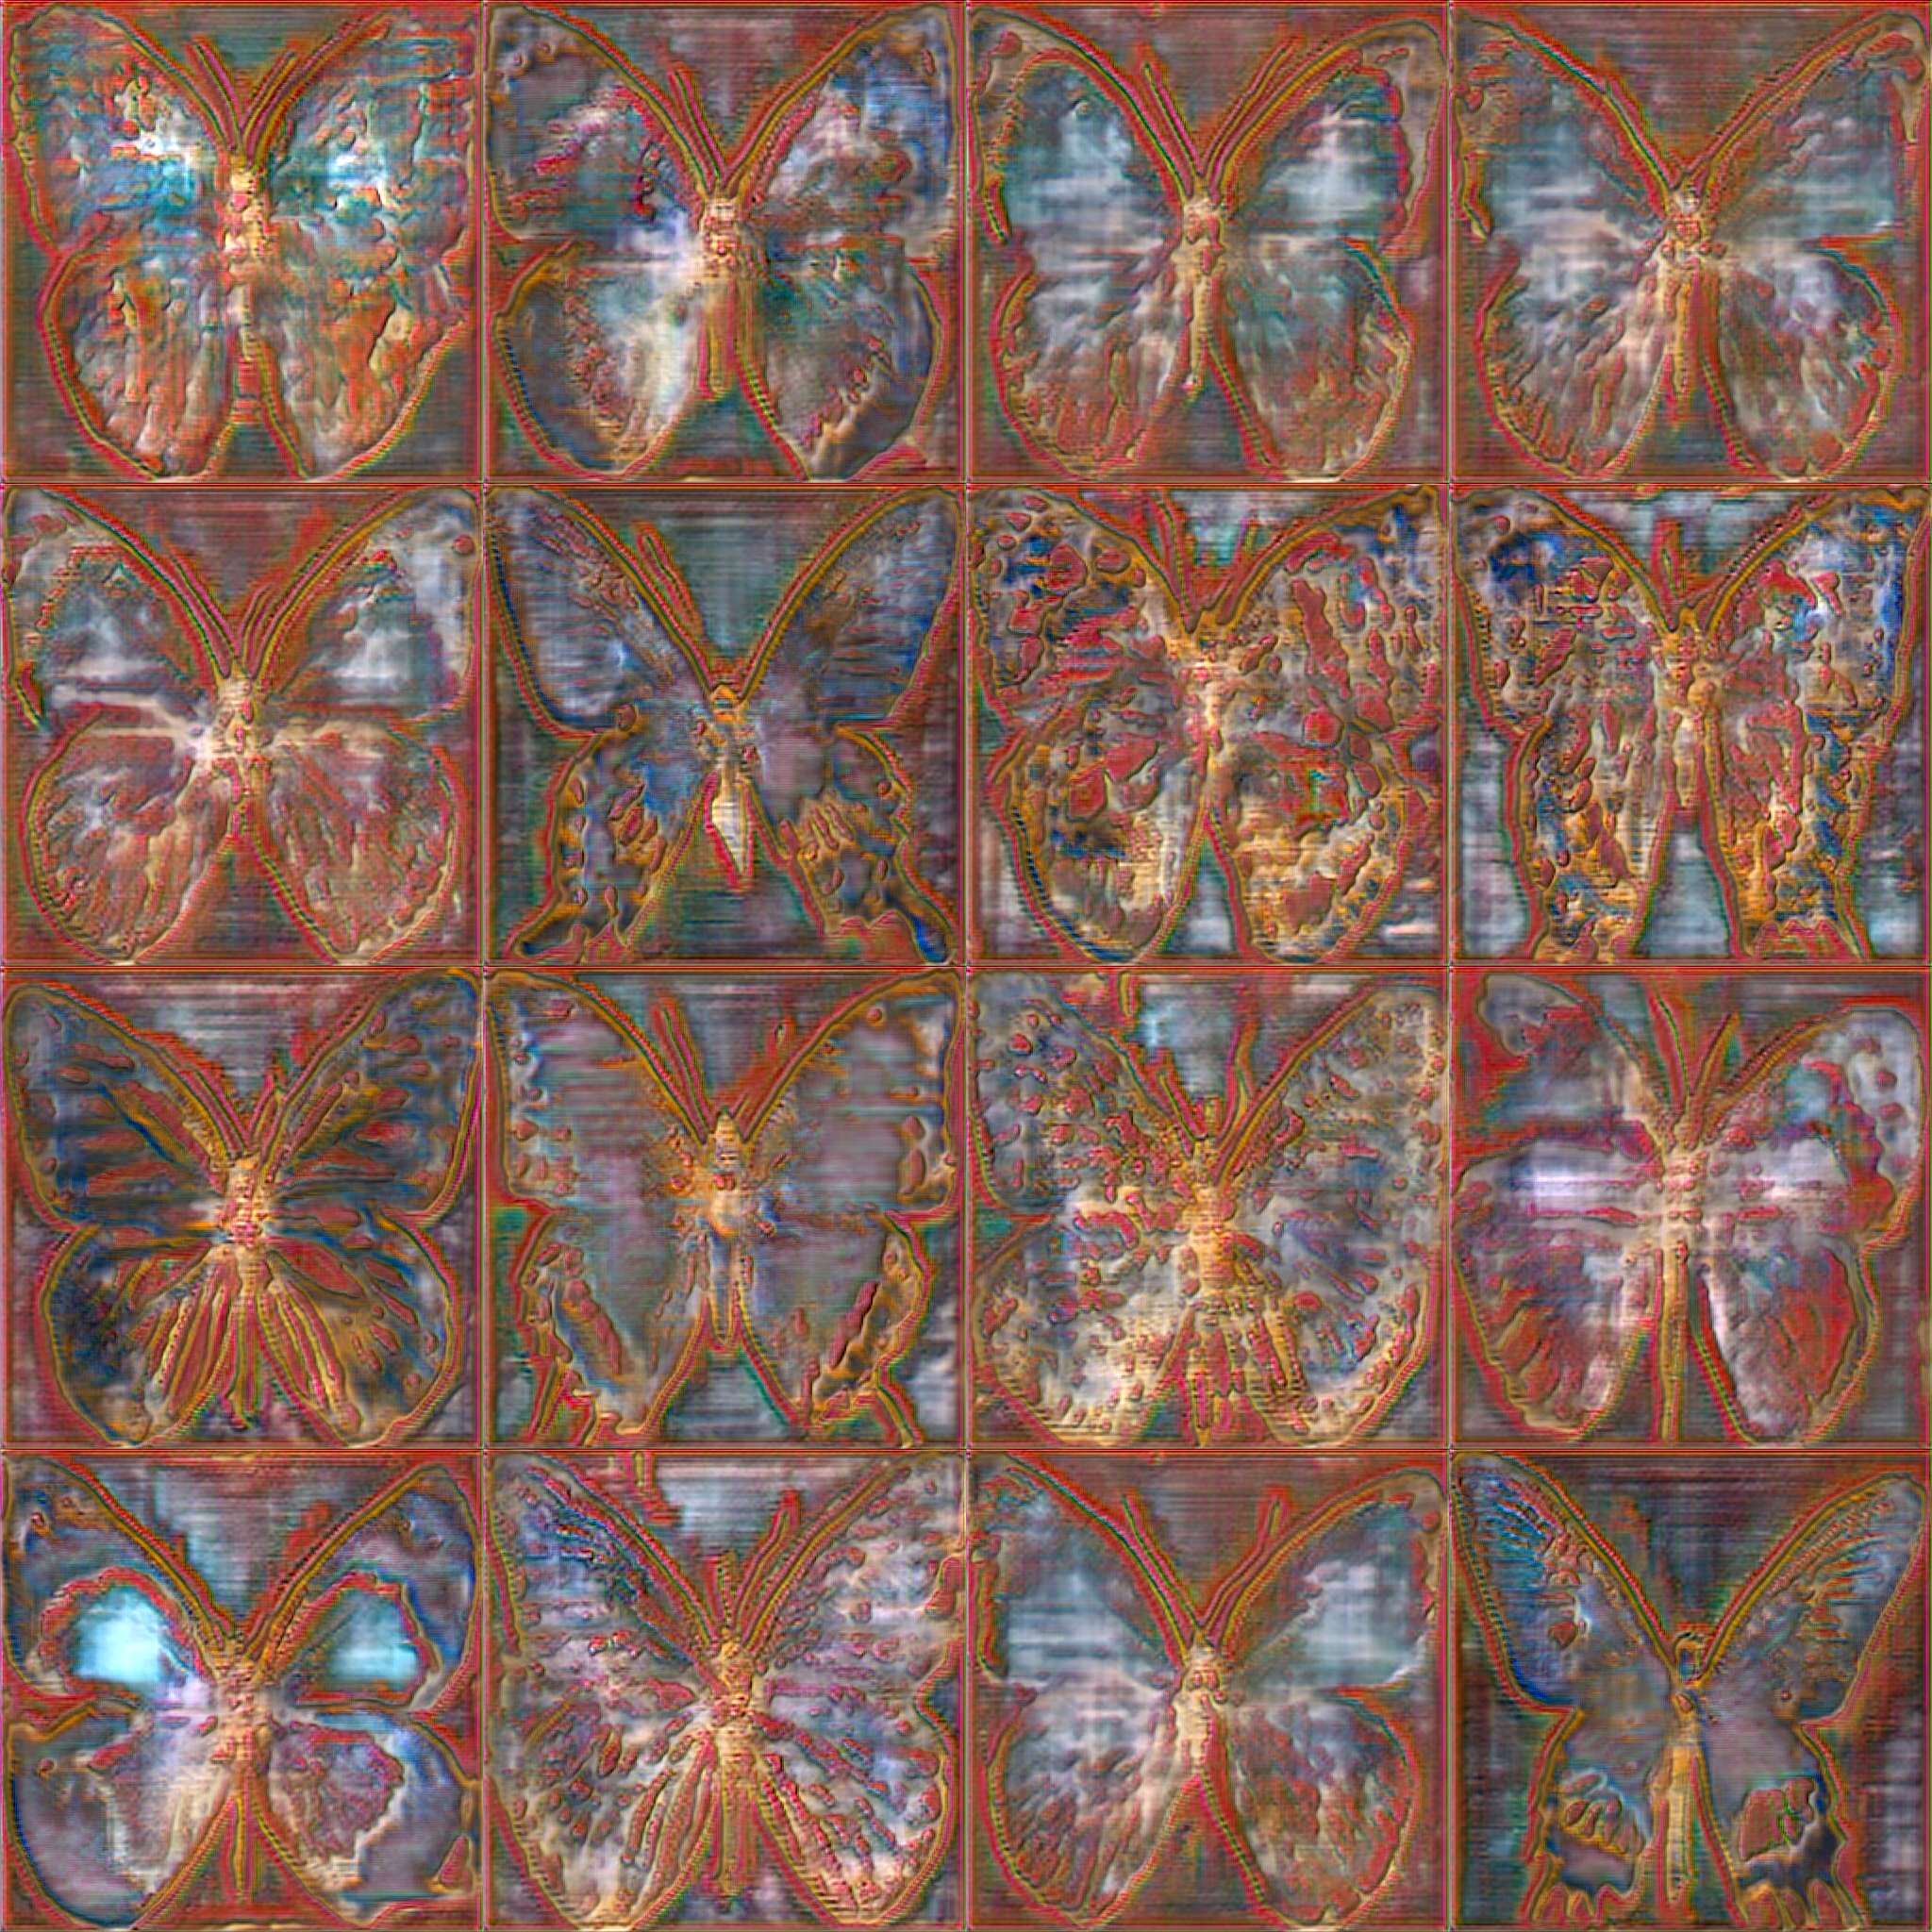

In [11]:
# @title Visualize outputs
exampleimgs = [generate_image_from_seed(bended_generator, seed=seeds[i]) for i in range(16)]
image_grid(exampleimgs, 4, 4)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
